# Data Access

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
import pandas as pd
from google.oauth2 import service_account
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy import stats, ndimage, interpolate
from sklearn.preprocessing import StandardScaler
import google.auth
warnings.filterwarnings('ignore')  # Suppresses all warnings

# Add parent directory to Python path for local imports
notebook_path = Path.cwd()  # Gets current working directory
project_root = notebook_path.parent.parent  # Navigate up to project root
sys.path.append(str(project_root))

# Local application imports
from src.mimicdf import MIMICDF
from src.preprocessing.data_preprocessor import DataPreprocessor

# Initialize MIMIC database connection to GCP
mimicdf = MIMICDF.create_connection()

# Initialize MIMIC demo database
# mimicdf = MIMICDF.create_demo()

Successfully connected to MIMIC-IV ED dataset


In [280]:
# Help
# printhelp(mimicdf)

ed_data = mimicdf.ed_data()


Loading edstays...
Table loaded: edstays
Loading demographics...
Table loaded: edstays
Table loaded: age
Loading age data...
Table loaded: age
Calculating ED visit age...
Merging time features...
Table loaded: edstays
Merging triage features...
Table loaded: triage
Cleaning up columns...

 Dataframe shape: (425087, 18) 

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         425087 non-null  Int64  
 1   stay_id            425087 non-null  Int64  
 2   gender             425087 non-null  object 
 3   arrival_transport  425087 non-null  object 
 4   disposition        425087 non-null  object 
 5   race               425087 non-null  object 
 6   age_at_ed          316465 non-null  Int64  
 7   dow                425087 non-null  object 
 8   hour               425087 non-null  int32  
 9   los_

## Data Quality Assessment

In [282]:

# Basic Statistics
ed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,425087.0,15008713.591347,2878486.35271,10000032.0,12517890.5,15016278.0,17499003.5,19999987.0
stay_id,425087.0,34997352.518205,2888341.541656,30000012.0,32497991.5,34993947.0,37503868.5,39999965.0
age_at_ed,316465.0,57.556292,19.552638,18.0,43.0,58.0,72.0,103.0
hour,425087.0,13.478267,5.890293,0.0,10.0,14.0,18.0,23.0
los_minutes,425087.0,429.499604,397.679997,-1364.0,212.0,328.0,499.0,29584.166667
temperature,401672.0,98.015046,4.008575,0.1,97.5,98.0,98.6,986.0
heartrate,407997.0,85.079891,18.04169,1.0,72.0,84.0,96.0,1228.0
resprate,404734.0,17.565521,5.485706,0.0,16.0,18.0,18.0,1820.0
o2sat,404491.0,98.471888,17.040807,0.0,97.0,99.0,100.0,9322.0
sbp,406796.0,135.395352,240.956408,1.0,120.0,133.0,148.0,151103.0


In [4]:
def plot_features_distribution(ed_data):
    plt.style.use('default')  # Using default style instead of seaborn
    features = ['age_at_ed', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
    n_features = len(features)
    n_rows = (n_features + 2) // 3  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()  # Flatten axes array for easier indexing

    for idx, feature in enumerate(features):
        # Create boxplot and histogram side by side
        ax = axes[idx]
        
        # Create violin plot with boxplot inside
        sns.violinplot(data=ed_data, y=feature, ax=ax, inner='box', color='lightblue')
        
        # Add title and labels
        ax.set_title(f'{feature} Distribution')
        ax.set_ylabel(feature)
        
        # Add text with basic statistics
        stats_text = f'Mean: {ed_data[feature].mean():.2f}\n'
        stats_text += f'Median: {ed_data[feature].median():.2f}\n'
        stats_text += f'Missing: {ed_data[feature].isna().sum()/len(ed_data)*100:.1f}%'
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Remove any empty subplots
    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Call the function with ed_data
# plot_features_distribution(ed_data)



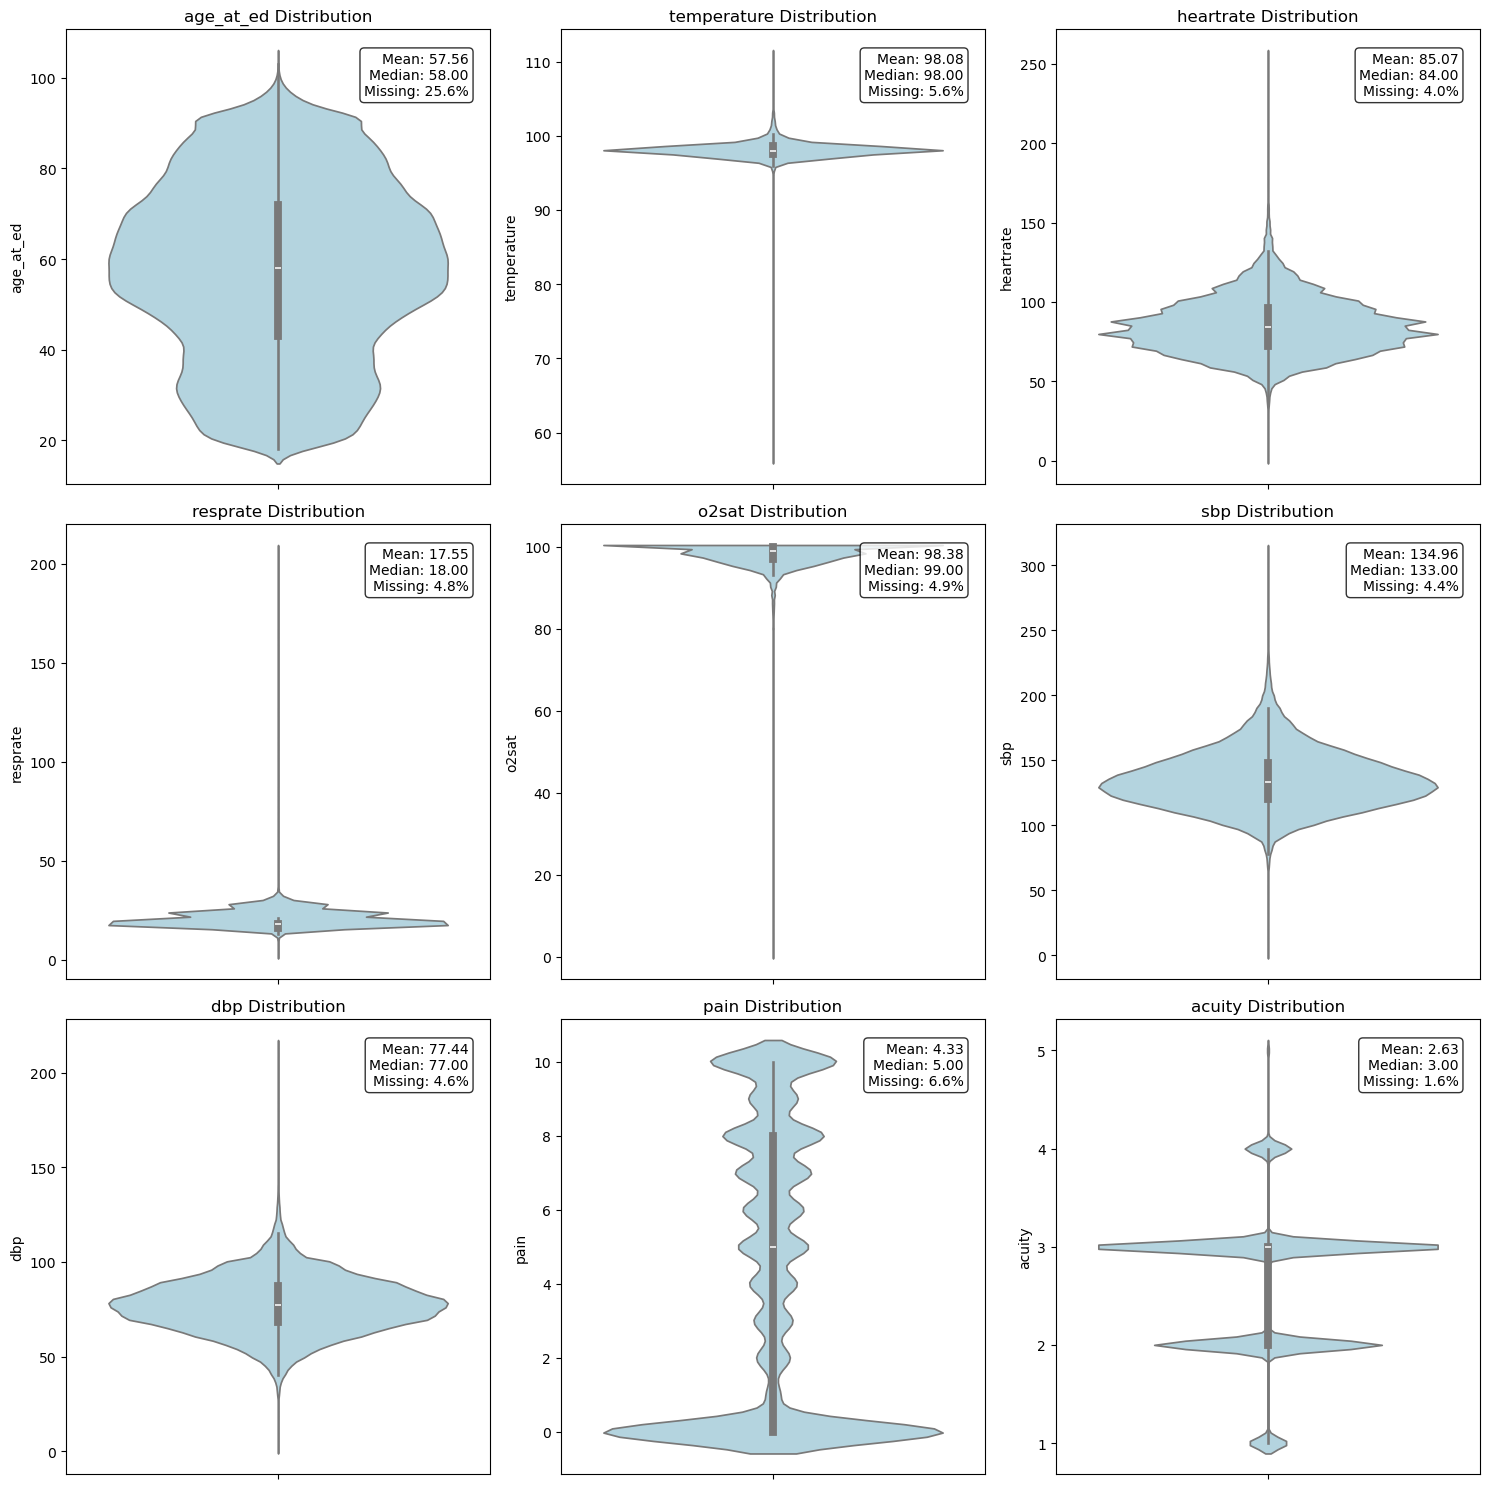

,count,mean,std,min,25%,50%,75%,max
subject_id,425087.0,15008713.591347,2878486.35271,10000032.0,12517890.5,15016278.0,17499003.5,19999987.0
stay_id,425087.0,34997352.518205,2888341.541656,30000012.0,32497991.5,34993947.0,37503868.5,39999965.0
age_at_ed,316465.0,57.556292,19.552638,18.0,43.0,58.0,72.0,103.0
hour,425087.0,13.478267,5.890293,0.0,10.0,14.0,18.0,23.0
los_minutes,425028.0,429.57145,397.643784,1.0,212.0,328.0,499.0,29584.166667
temperature,401186.0,98.082329,1.009903,56.0,97.5,98.0,98.6,111.4
heartrate,407990.0,85.065149,17.668252,1.0,72.0,84.0,96.0,256.0
resprate,404728.0,17.552403,2.532458,1.0,16.0,18.0,18.0,209.0
o2sat,404444.0,98.375121,2.457111,0.0,97.0,99.0,100.0,100.0
sbp,406195.0,134.956367,22.345995,1.0,120.0,133.0,148.0,312.0


In [5]:
# Preprocess ed_data to handle invlaid values
data_preprocessor = DataPreprocessor(ed_data)
cleaned_data = data_preprocessor.prepare_data()

plot_features_distribution(cleaned_data)
cleaned_data.describe().T

## Missingness Analysis

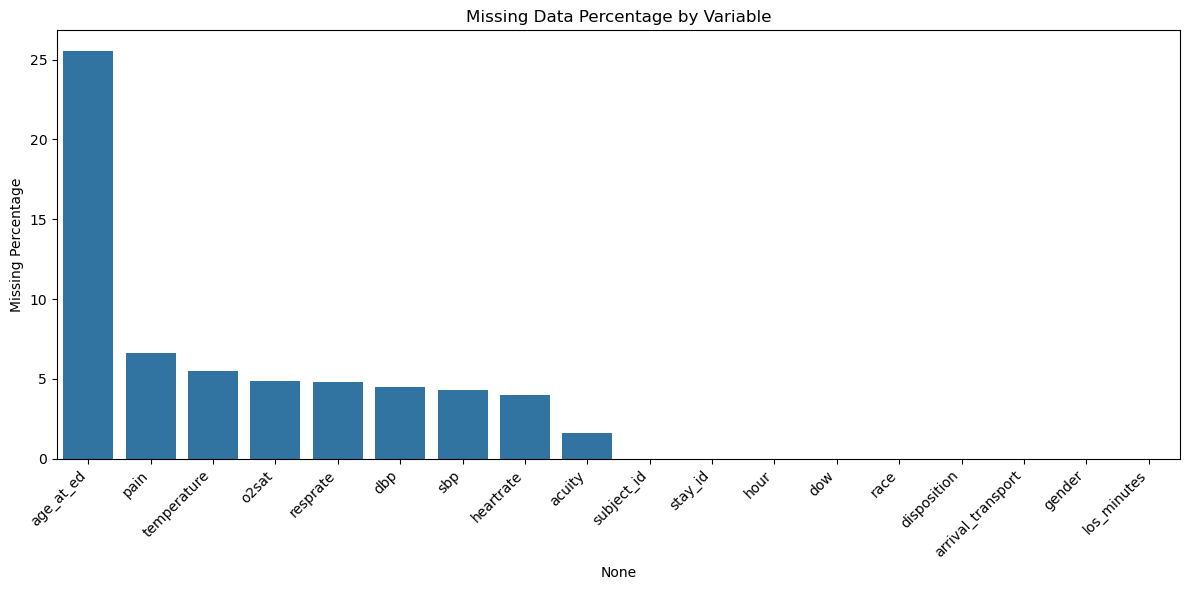

In [283]:
# 1. Overall missingness by column

def initial_missingness_analysis(data):
    """
    Perform initial analysis of missingness patterns in the dataset
    """
    
    missing_summary = pd.DataFrame({
        'Missing_Count': data.isnull().sum(),
        'Missing_Percentage': (data.isnull().sum() / len(data) * 100).round(2)
    }).sort_values('Missing_Percentage', ascending=False)
    
    # 2. Visualize missingness patterns
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_summary.index, 
                y='Missing_Percentage',
                data=missing_summary)
    plt.xticks(rotation=45, ha='right')
    plt.title('Missing Data Percentage by Variable')
    plt.ylabel('Missing Percentage')
    plt.tight_layout()
    plt.show()
    
    
    return missing_summary

# Run initial analysis
missing_summary = initial_missingness_analysis(ed_data)

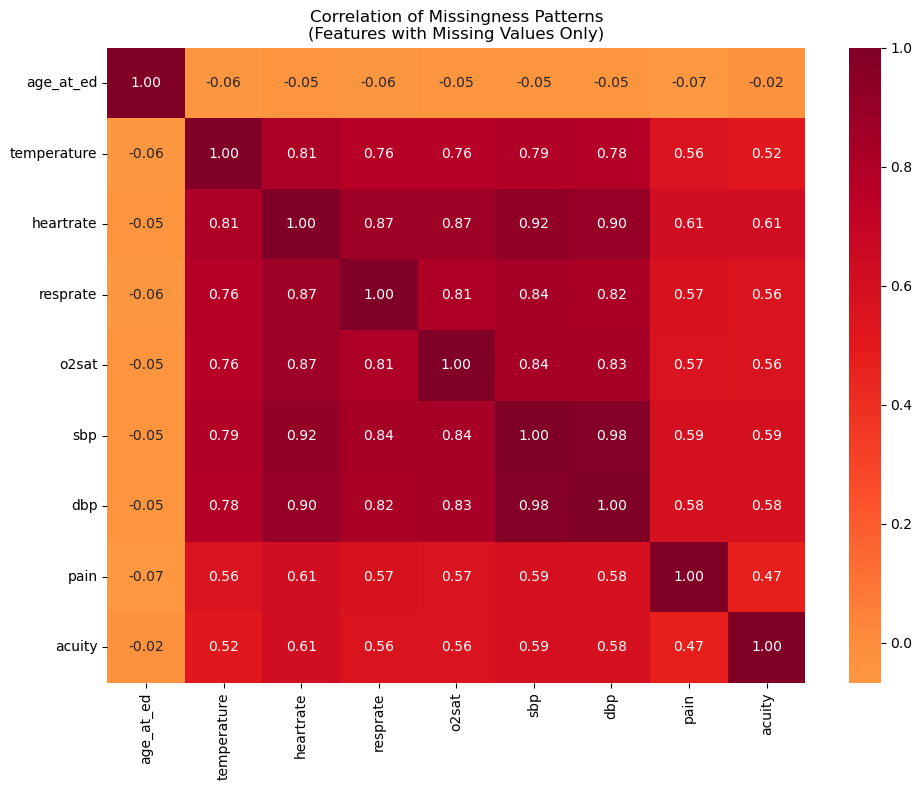

In [284]:
# # 2. Correlation heatmap only for features with missing values

def analyze_missingness(data):

    missing_features = ['age_at_ed', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
    features_with_missing = missing_features
    
    # Create binary missingness indicators only for features with missing values
    missing_binary = data[features_with_missing].isnull().astype(int)
    
    # Compute correlation between missing indicators
    missing_corr = missing_binary.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(missing_corr, 
                annot=True, 
                cmap='YlOrRd',
                fmt='.2f',
                center=0)
    plt.title('Correlation of Missingness Patterns\n(Features with Missing Values Only)')
    plt.tight_layout()
    plt.show()
    
    return missing_corr

missing_corr = analyze_missingness(ed_data)



1. Strong Correlations Among Vitals (0.75-0.98):
    - Temperature, heartrate, resprate, o2sat, sbp, and dbp show very high correlations (dark red)
    - This suggests these vitals tend to be missing together
    - Makes sense clinically as they're usually measured in the same assessment
2. Age Independence (-0.02 to -0.07):
    - Age missingness shows very weak negative correlations with vital signs
    - Suggets that age must be handled separately

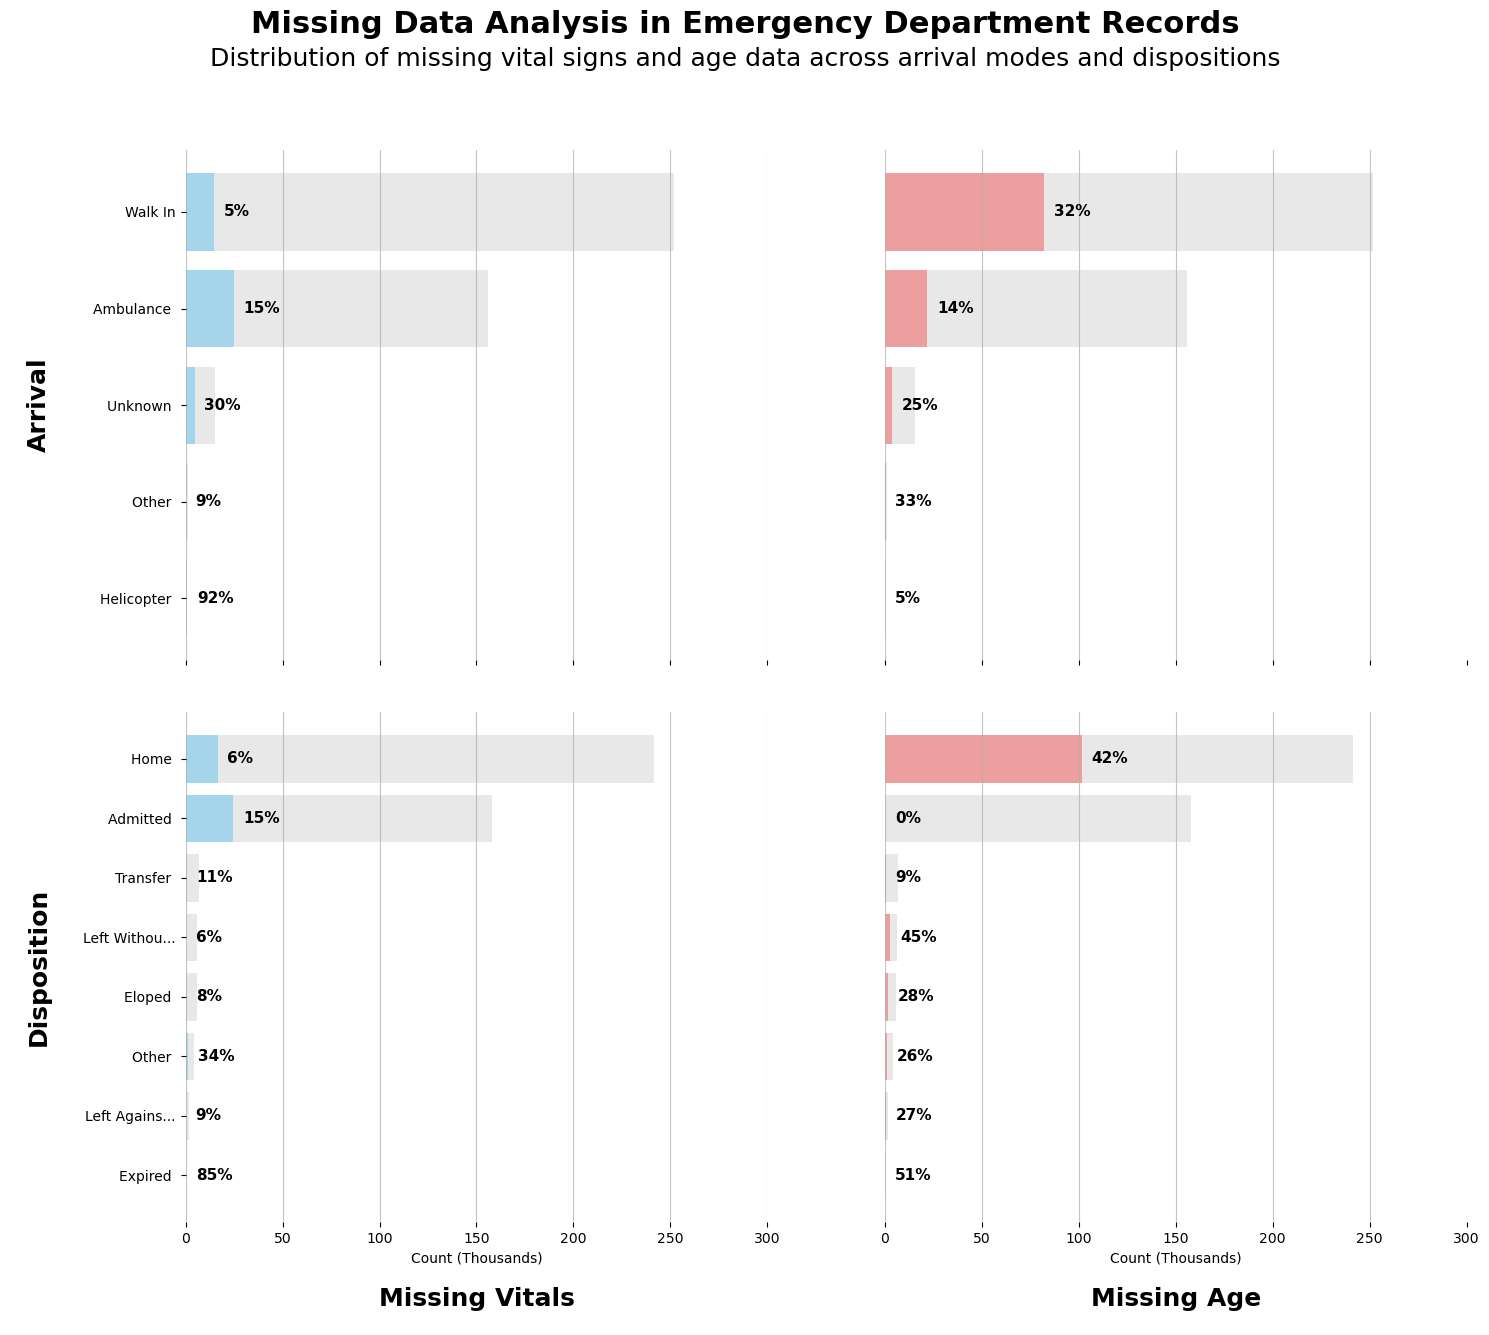

In [285]:
def missing_counts(data):
    """
    Prepares data for missing counts analysis
    """
    # Define vital signs
    vital_signs = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
    
    # Create a copy of data to avoid modifications to original
    _df = data.copy()
    
    # Create missing indicators
    _df['missing_vitals'] = _df[vital_signs].isnull().any(axis=1).astype(int)
    _df['missing_age'] = _df['age_at_ed'].isnull().astype(int)
    
    # Keep only relevant columns
    _df = _df[['missing_vitals', 'missing_age', 'arrival_transport', 'disposition']].reset_index(drop=True)
    
    return _df

def missing_counts_graph_annotated(data):
    """
    Creates a 2x2 grid of charts analyzing missing data patterns
    with annotations of missingness ratios.
    """
    # Process the data (assuming 'missing_counts' is a function you have defined)
    _df = missing_counts(data)

    # Create figure with more space for titles
    fig = plt.figure(figsize=(15, 14))
    
    # Create GridSpec to allow for row labels and column labels
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.1], width_ratios=[0.1, 1, 1])
    
    # Create main subplot axes (2 rows, 2 columns)
    axes = np.array([
        [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])],
        [fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]
    ])

    # Remove spines and format all subplots
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # Format x-axis in thousands
        ax.xaxis.set_major_formatter(lambda x, p: f'{int(x/1000)}')
        ax.grid(True, axis='x', alpha=0.75)
        # Adjust as needed
        ax.set_xlim(0, 300000)

    # Remove x-axis labels and spines for the top row
    axes[0,0].xaxis.set_ticklabels([])
    axes[0,1].xaxis.set_ticklabels([])
    axes[0,0].spines['bottom'].set_visible(False)
    axes[0,1].spines['bottom'].set_visible(False)

    # Remove y-axis labels and spine for the right side
    axes[0,1].yaxis.set_visible(False)
    axes[0,1].spines['left'].set_visible(False)
    axes[1,1].yaxis.set_visible(False)
    axes[1,1].spines['left'].set_visible(False)

    # Add 'Count' label for bottom row
    axes[1,0].set_xlabel('Count (Thousands)')
    axes[1,1].set_xlabel('Count (Thousands)')

    # Add row labels (rotated 90 degrees)
    row_labels = ['Arrival', 'Disposition']
    for idx, label in enumerate(row_labels):
        fig.add_subplot(gs[idx, 0]).text(0.5, 0.5, label, 
                                         rotation=90, 
                                         ha='center', 
                                         va='center',
                                         fontsize=18,
                                         fontweight='bold')
        plt.axis('off')  # Hide the axis for the label subplots

    # Add column labels at the bottom
    col_labels = ['Missing Vitals', 'Missing Age']
    for idx, label in enumerate(col_labels):
        fig.add_subplot(gs[2, idx+1]).text(0.5, 0.5, label,
                                           ha='center',
                                           va='center',
                                           fontsize=18,
                                           fontweight='bold')
        plt.axis('off')

    # Add title and subtitle
    fig.suptitle('Missing Data Analysis in Emergency Department Records', 
                 y=0.95, fontsize=22, weight='bold')
    plt.figtext(0.5, 0.91, 
                'Distribution of missing vital signs and age data across arrival modes and dispositions',
                ha='center', fontsize=18)

    # Helper function to convert to camel case (for y-tick labels)
    def to_camel_case(text):
        words = text.replace('_', ' ').title().split()
        camel_case = words[0] + ' ' + ' '.join(word.capitalize() for word in words[1:])
        return camel_case if len(camel_case) <= 15 else camel_case[:11] + '...'

    # 1) Missing Vitals by arrival_transport (top-left)
    transport_counts = _df.groupby('arrival_transport').size()
    missing_vitals_counts = _df.groupby('arrival_transport')['missing_vitals'].sum()
    sort_idx = transport_counts.sort_values(ascending=True).index
    transport_counts = transport_counts[sort_idx]
    missing_vitals_counts = missing_vitals_counts[sort_idx]
    
    ax = axes[0,0]
    y_pos = np.arange(len(transport_counts))

    ax.barh(y_pos, transport_counts, color='lightgray', alpha=0.5, label='Total Count')
    bars_vitals = ax.barh(y_pos, missing_vitals_counts, color='skyblue', alpha=0.7, label='Missing Vitals')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([to_camel_case(str(x)) for x in sort_idx])

    # Annotate missing_vitals bars with ratio (no decimals, e.g. 25%)
    for i, bar in enumerate(bars_vitals):
        total_val = transport_counts.iloc[i]
        missing_val = missing_vitals_counts.iloc[i]
        if total_val > 0:
            ratio = int((missing_val / total_val) * 100)  # no decimals
            x_bar = bar.get_width()
            y_bar = bar.get_y() + bar.get_height() / 2
            # Place text just to the right of the bar
            ax.text(x_bar + 5000,
                    y_bar,
                    f"{ratio}%",
                    va='center', ha='left',
                    color='black',
                    fontsize=11,
                    fontweight='bold')

    # 2) Missing Vitals by disposition (bottom-left)
    disposition_counts = _df.groupby('disposition').size()
    missing_vitals_counts = _df.groupby('disposition')['missing_vitals'].sum()
    sort_idx = disposition_counts.sort_values(ascending=True).index
    disposition_counts = disposition_counts[sort_idx]
    missing_vitals_counts = missing_vitals_counts[sort_idx]
    
    ax = axes[1,0]
    y_pos = np.arange(len(disposition_counts))

    ax.barh(y_pos, disposition_counts, color='lightgray', alpha=0.5, label='Total Count')
    bars_vitals = ax.barh(y_pos, missing_vitals_counts, color='skyblue', alpha=0.7, label='Missing Vitals')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([to_camel_case(str(x)) for x in sort_idx])

    # Annotate missing_vitals bars with ratio
    for i, bar in enumerate(bars_vitals):
        total_val = disposition_counts.iloc[i]
        missing_val = missing_vitals_counts.iloc[i]
        if total_val > 0:
            ratio = int((missing_val / total_val) * 100)
            x_bar = bar.get_width()
            y_bar = bar.get_y() + bar.get_height() / 2
            ax.text(x_bar + 5000,
                    y_bar,
                    f"{ratio}%",
                    va='center', ha='left',
                    color='black',
                    fontsize=11,
                    fontweight='bold')

    # 3) Missing Age by arrival_transport (top-right)
    arrival_transport_counts = _df.groupby('arrival_transport').size()
    missing_age_counts = _df.groupby('arrival_transport')['missing_age'].sum()
    sort_idx = arrival_transport_counts.sort_values(ascending=True).index
    arrival_transport_counts = arrival_transport_counts[sort_idx]
    missing_age_counts = missing_age_counts[sort_idx]
    
    ax = axes[0,1]
    y_pos = np.arange(len(missing_age_counts))

    ax.barh(y_pos, arrival_transport_counts, color='lightgray', alpha=0.5, label='Total Count')
    bars_age = ax.barh(y_pos, missing_age_counts, color='lightcoral', alpha=0.7, label='Missing Age')
    
    # Annotate missing_age bars with ratio
    for i, bar in enumerate(bars_age):
        total_val = arrival_transport_counts.iloc[i]
        missing_val = missing_age_counts.iloc[i]
        if total_val > 0:
            ratio = int((missing_val / total_val) * 100)
            x_bar = bar.get_width()
            y_bar = bar.get_y() + bar.get_height() / 2
            ax.text(x_bar + 5000,
                    y_bar,
                    f"{ratio}%",
                    va='center', ha='left',
                    color='black',
                    fontsize=11,
                    fontweight='bold')

    # 4) Missing Age by disposition (bottom-right)
    disposition_counts = _df.groupby('disposition').size()
    missing_age_counts = _df.groupby('disposition')['missing_age'].sum()
    sort_idx = disposition_counts.sort_values(ascending=True).index
    disposition_counts = disposition_counts[sort_idx]
    missing_age_counts = missing_age_counts[sort_idx]
    
    ax = axes[1,1]
    y_pos = np.arange(len(missing_age_counts))

    ax.barh(y_pos, disposition_counts, color='lightgray', alpha=0.5, label='Total Count')
    bars_age = ax.barh(y_pos, missing_age_counts, color='lightcoral', alpha=0.7, label='Missing Age')
    
    # Annotate missing_age bars with ratio
    for i, bar in enumerate(bars_age):
        total_val = disposition_counts.iloc[i]
        missing_val = missing_age_counts.iloc[i]
        if total_val > 0:
            ratio = int((missing_val / total_val) * 100)
            x_bar = bar.get_width()
            y_bar = bar.get_y() + bar.get_height() / 2
            ax.text(x_bar + 5000,
                    y_bar,
                    f"{ratio}%",
                    va='center', ha='left',
                    color='black',
                    fontsize=11,
                    fontweight='bold')

    plt.tight_layout()
    # Adjust layout to make room for the main title
    plt.subplots_adjust(top=0.85)
    plt.show()

missing_counts_graph_annotated(ed_data)

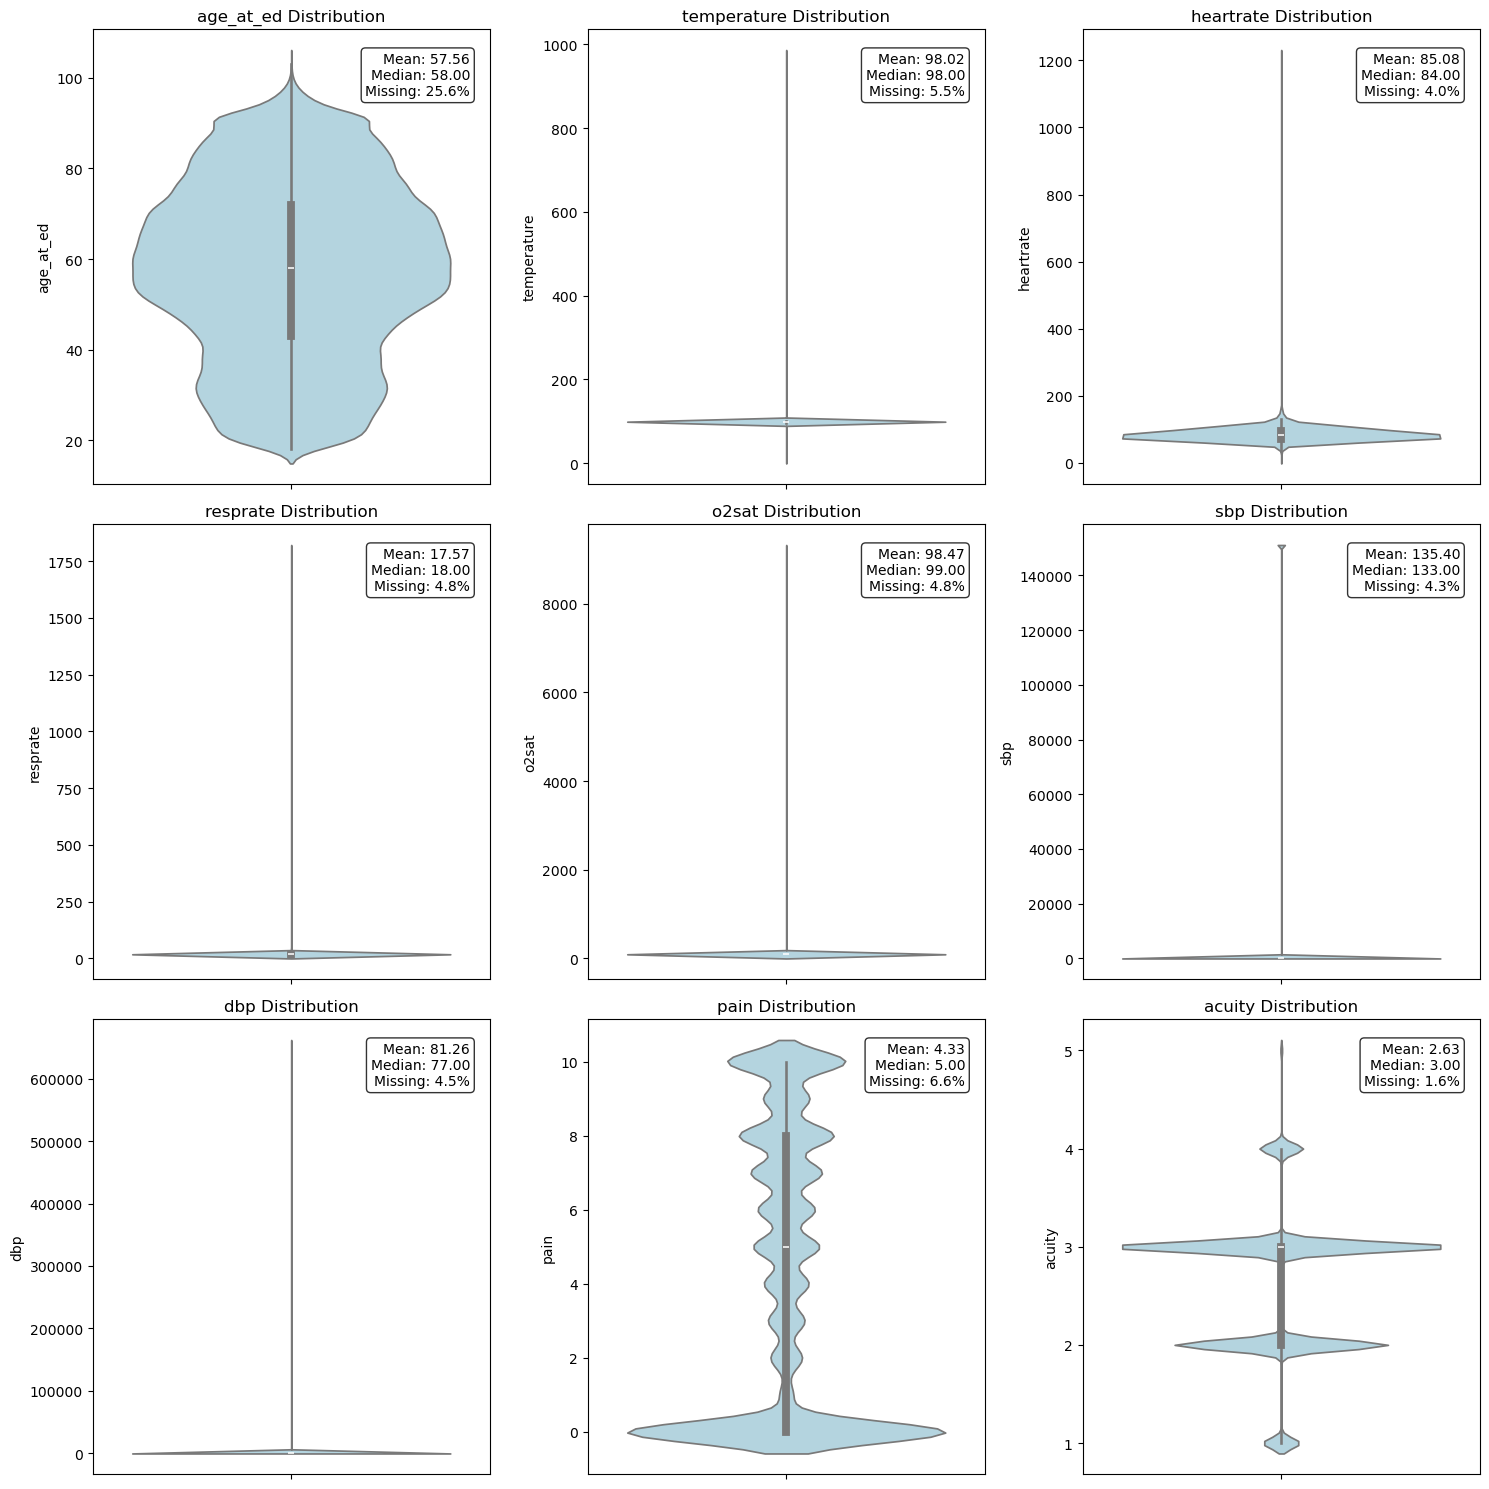

In [286]:
def plot_features_distribution(ed_data):
    plt.style.use('default')  # Using default style instead of seaborn
    features = ['age_at_ed', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
    n_features = len(features)
    n_rows = (n_features + 2) // 3  # Calculate number of rows needed

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()  # Flatten axes array for easier indexing

    for idx, feature in enumerate(features):
        # Create boxplot and histogram side by side
        ax = axes[idx]
        
        # Create violin plot with boxplot inside
        sns.violinplot(data=ed_data, y=feature, ax=ax, inner='box', color='lightblue')
        
        # Add title and labels
        ax.set_title(f'{feature} Distribution')
        ax.set_ylabel(feature)
        
        # Add text with basic statistics
        stats_text = f'Mean: {ed_data[feature].mean():.2f}\n'
        stats_text += f'Median: {ed_data[feature].median():.2f}\n'
        stats_text += f'Missing: {ed_data[feature].isna().sum()/len(ed_data)*100:.1f}%'
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Remove any empty subplots
    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Call the function with ed_data
plot_features_distribution(ed_data)



## Cohort Selection

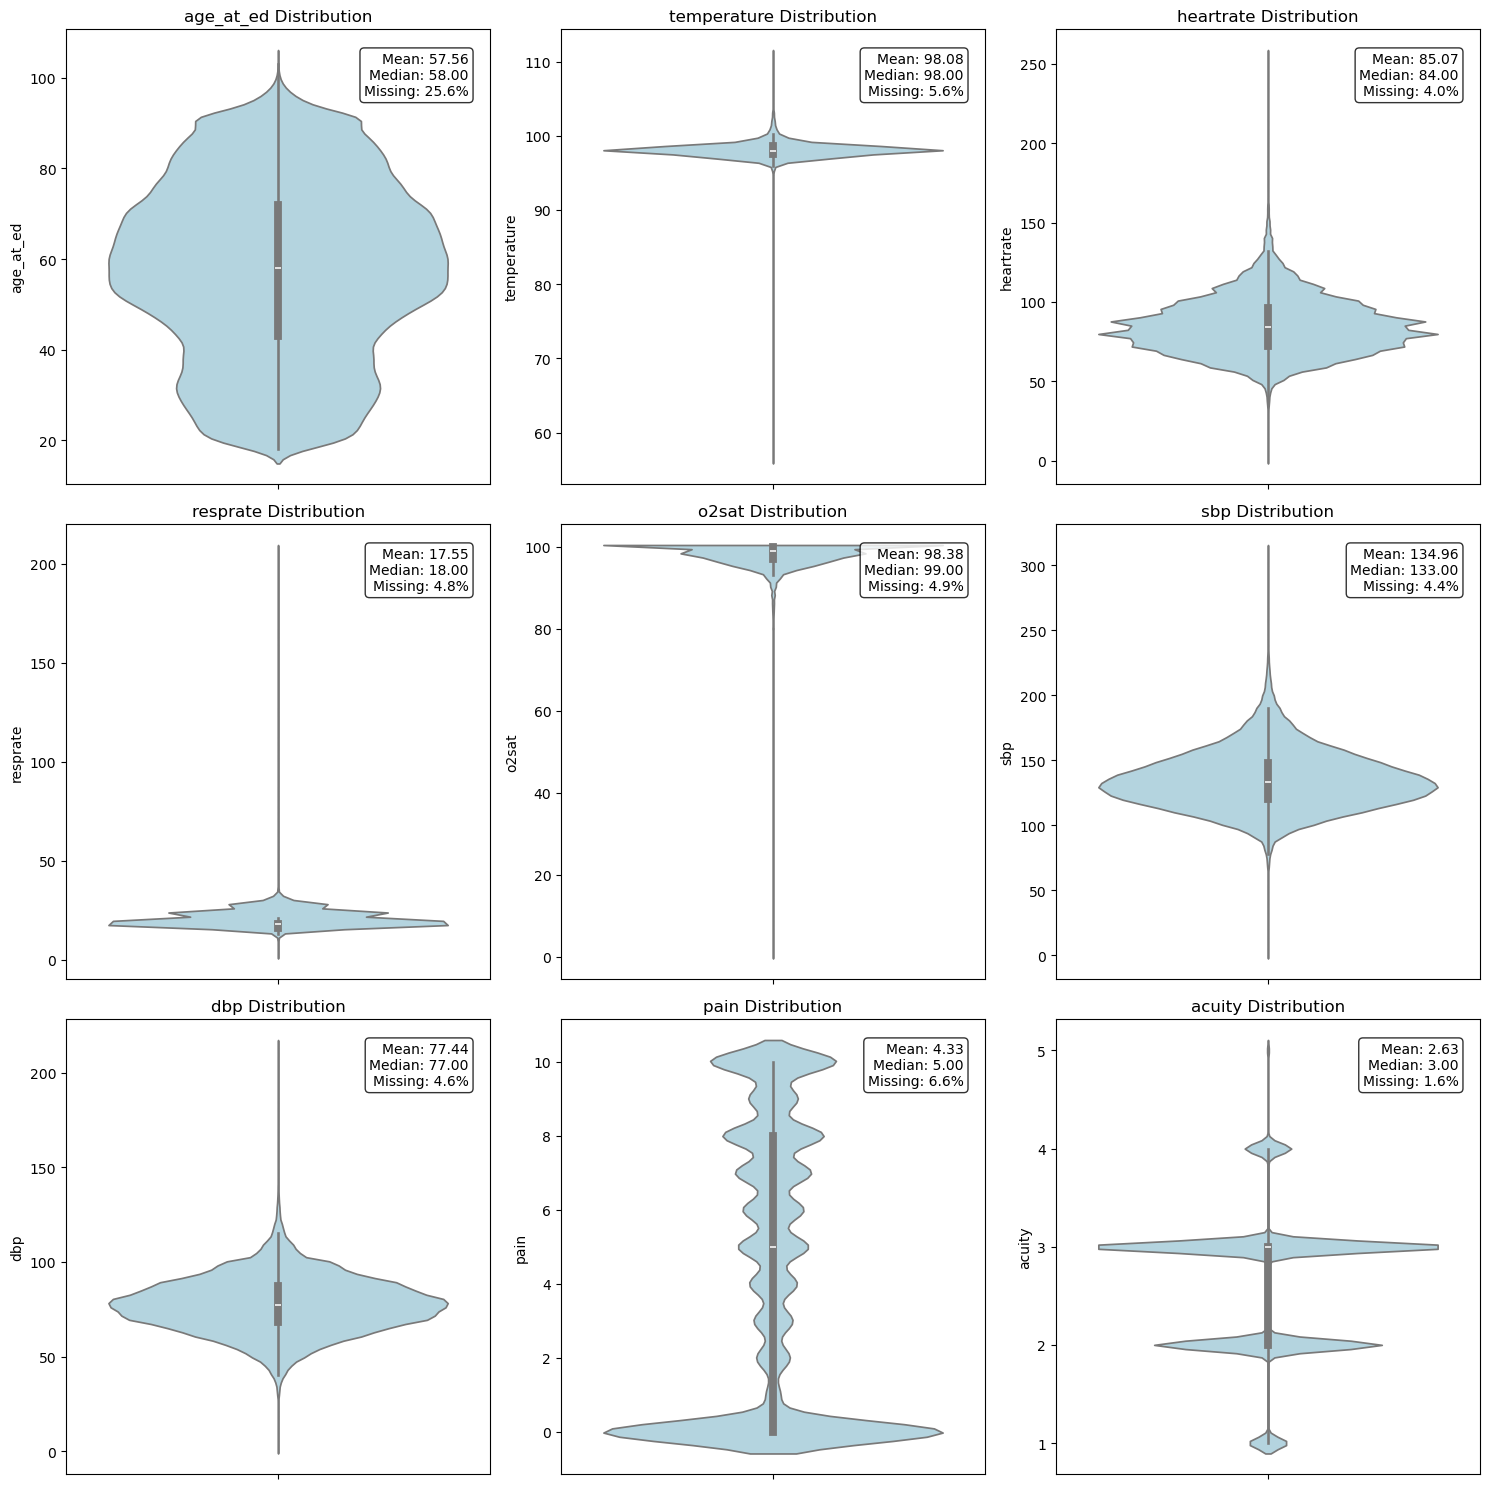

,count,mean,std,min,25%,50%,75%,max
subject_id,425087.0,15008713.591347,2878486.35271,10000032.0,12517890.5,15016278.0,17499003.5,19999987.0
stay_id,425087.0,34997352.518205,2888341.541656,30000012.0,32497991.5,34993947.0,37503868.5,39999965.0
age_at_ed,316465.0,57.556292,19.552638,18.0,43.0,58.0,72.0,103.0
hour,425087.0,13.478267,5.890293,0.0,10.0,14.0,18.0,23.0
los_minutes,425028.0,429.57145,397.643784,1.0,212.0,328.0,499.0,29584.166667
temperature,401186.0,98.082329,1.009903,56.0,97.5,98.0,98.6,111.4
heartrate,407990.0,85.065149,17.668252,1.0,72.0,84.0,96.0,256.0
resprate,404728.0,17.552403,2.532458,1.0,16.0,18.0,18.0,209.0
o2sat,404444.0,98.375121,2.457111,0.0,97.0,99.0,100.0,100.0
sbp,406195.0,134.956367,22.345995,1.0,120.0,133.0,148.0,312.0


In [287]:
# Preprocess ed_data to handle invlaid values
data_preprocessor = DataPreprocessor(ed_data)
cleaned_data = data_preprocessor.prepare_data()

plot_features_distribution(cleaned_data)
cleaned_data.describe().T

# Data Exploration

# Data Preprocessing